In [ ]:
%matplotlib inline


# Deep Convolutional Generative Adversarial Network (DC-GAN) Tutorial

**Author**: [Nathan Inkawhich](https://github.com/inkawhich)


## Introduction

This tutorial will give an introduction to DCGANs through an example. We
will train a generative adversarial network (GAN) to generate new
celebrities after showing it pictures of many real celebrities. Most of
the code here is from the dcgan implementation in
[pytorch/examples](https://github.com/pytorch/examples)_, and this
document will give a thorough explanation of the implementation and shed
light on how and why this model works. But don’t worry, no prior
knowledge of GANs is required, but it may require a first-timer to spend
some time reasoning about what is actually happening under the hood.
Also, for the sake of time it will help to have a GPU, or two. Lets
start from the beginning.

## Generative Adversarial Networks

### What is a GAN?

GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper [Generative Adversarial
Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_.
They are made of two distinct models, a *generator* and a
*discriminator*. The job of the generator is to spawn ‘fake’ images that
look like the training images. The job of the discriminator is to look
at an image and output whether or not it is a real training image or a
fake image from the generator. During training, the generator is
constantly trying to outsmart the discriminator by generating better and
better fakes, while the discriminator is working to become a better
detective and correctly classify the real and fake images. The
equilibrium of this game is when the generator is generating perfect
fakes that look as if they came directly from the training data, and the
discriminator is left to always guess at 50% confidence that the
generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images, the input to
$D(x)$ is an image of CHW size 3x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in [Goodfellow’s
paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(z)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

In theory, the solution to this minimax game is where
$p_g = p_{data}$, and the discriminator guesses randomly if the
inputs are real or fake. However, the convergence theory of GANs is
still being actively researched and in reality models do not always
train to this point.

### What is a DCGAN?

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper [Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks](https://arxiv.org/pdf/1511.06434.pdf)_. The discriminator
is made up of strided
[convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)_
layers, [batch
norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)_
layers, and
[LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)_
activations. The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.
The generator is comprised of
[convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d)_
layers, batch norm layers, and
[ReLU](https://pytorch.org/docs/stable/nn.html#relu)_ activations. The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.




In [ ]:
from __future__ import print_function
#%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
from PIL import Image

import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Inputs

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [ ]:
# Root directory for dataset
dataroot = "data/faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In this tutorial we will use the [Celeb-A Faces
dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)_ which can
be downloaded at the linked site, or in [Google
Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)_.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




The following code is related to loading and preprocessing image data for a deep learning model training. Here are the details of the code:

1-The dset.ImageFolder() function from PyTorch's torchvision.datasets module is used to load a dataset from a specified directory root, where each subdirectory is assumed to contain images of a specific class.

2-The transforms.Compose() function from torchvision.transforms module is used to define a sequence of image transformations to be applied to the dataset.

3-The specified sequence of transformations includes transforms.Resize(), which resizes the images to a specified size, transforms.CenterCrop(), which crops the center of the images, transforms.ToTensor(), which converts the image data to PyTorch tensors, and transforms.Normalize(), which normalizes the image data by subtracting the mean and dividing by the standard deviation.

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
#Resize, Centercrop, tensor conversion and normalize the image data
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

The resulting dataset is then wrapped in a PyTorch DataLoader object, which allows for efficient batching, shuffling, and loading of the data during training.

In [12]:
# Create the dataloader from the dataset with shuffling and defining the batch size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

The device (CPU or GPU) is selected based on the availability of CUDA and the specified ngpu variable.

In [13]:
# Decide which device we want to run on, if one or more GPU is available then the GPU will be used otherwise CPU will be used to RUN.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Finally, the plt.imshow() function from the matplotlib.pyplot module is used to plot some training images, which are obtained using the next(iter(dataloader)) function call. This line creates an image grid using the make_grid function from the vutils (visualization utilities) module of PyTorch. It takes the first 64 images from the real_batch tensor and arranges them in a grid with 2 pixels of padding between each image. The images are then normalized and transposed to the shape (batch_size, height, width, channels) so they can be displayed using imshow from Matplotlib. Finally, cpu() is called to move the image data from the GPU to the CPU (if running on a GPU) before it can be displayed.

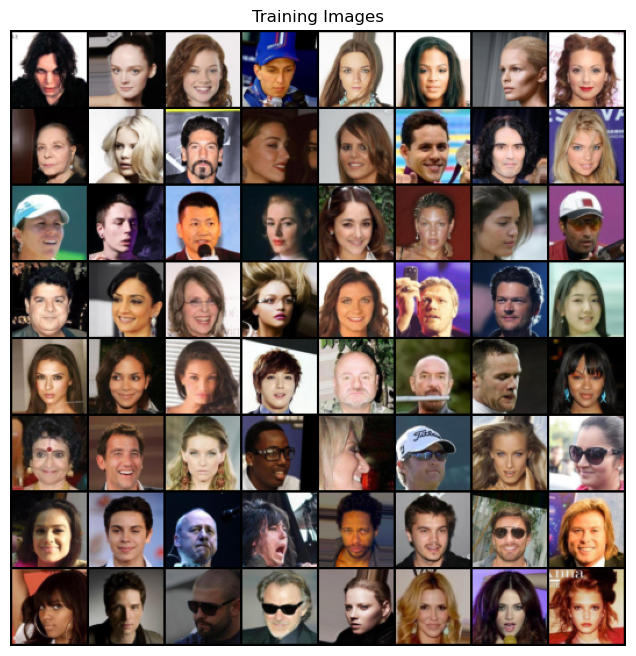

In [14]:
# Plot some training images

#This line loads the next batch of training images from a PyTorch DataLoader object
real_batch = next(iter(dataloader))
#This line creates a new figure for plotting the images, with a size of 8x8.
plt.figure(figsize=(8,8))
#This line removes the axes from the plot.
plt.axis("off")
#This line adds a title to the plot
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

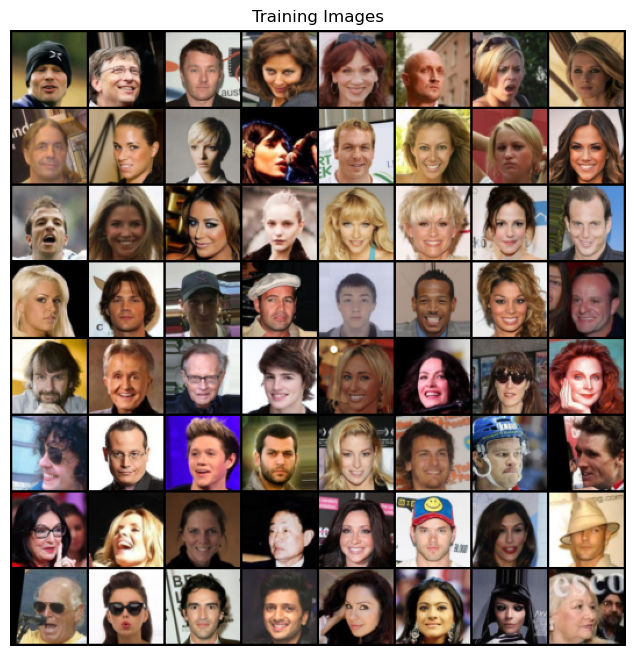

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Implementation

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.


### Weight Initialization
Before we begin initializing the weights of the neural network is an essential step in training deep learning models. Proper initialization of weights can help to accelerate the convergence of the model and improve its ability to generalize to new data.

In the DCGAN architecture, the generator and discriminator models are deep neural networks with many layers. Random initialization of the weights in these models may lead to some of the weights having very large or very small magnitudes, which can result in unstable training and poor performance.

To address this issue, the weights_init function initializes the weights in the generator and discriminator models using a normal distribution with mean 0 and standard deviation 0.02. This initialization ensures that the weights are initially close to zero, which can help to stabilize the training process and accelerate convergence.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

This step of weight initialization is an important step in the training process of deep neural networks and can have a significant impact on the final performance of the model.

### Generator

In a Generative Adversarial Network (GAN), the generator model takes in a random noise vector as input and generates a fake image that resembles the real images in the dataset. The goal of the generator is to produce images that are indistinguishable from the real images. The generator model typically consists of a series of deconvolutional layers, also called transpose convolutional layers, that learn to upsample the input noise into an image.

In this tutorial, since we are using a Deep Convolutional GAN (DCGAN) architecture so we would follow the same for the generator. DCGAN is a GAN architecture that uses deep convolutional neural networks to generate high-quality images. The DCGAN generator consists of several deconvolutional layers followed by batch normalization and ReLU activation.

Here's a step-by-step explanation of how to create a generator model using the DCGAN architecture:

Step 1: Define the Generator class:

Step 2: Initialize the class and define the layers in the constructor:

Notice, how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images).

Step 3: Define a forward method:

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

The generator has five deconvolutional layers, followed by a Tanh activation function that maps the output to the range [-1, 1]. The first layer takes a nz-dimensional noise vector as input, and each subsequent layer gradually upsamples the input to produce a 64x64 RGB image.

In the constructor of the Generator class, we define the layers that make up the generator model. Let's deep dive into the details of each layer with some real values for the length of the input vector, size of the feature maps and number of channels:

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [2]:
# Layer 1
# nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)

The first layer is a transposed convolutional layer that takes in a 100-dimensional noise vector as input and outputs a tensor of shape (512, 4, 4). The parameters of this layer are defined as follows:

100: the number of input channels (i.e., the size of the noise vector)
512: the number of output channels (i.e., the number of filters)
4: the kernel size
1: the stride
0: the padding
bias=False: we set this to False because we're using batch normalization, which already includes a bias term.

In [3]:
# Layer 2
# nn.BatchNorm2d(512)

After the first convolutional layer, we apply batch normalization to normalize the output of the previous layer. Batch normalization helps to stabilize the training process by reducing the internal covariate shift. The BatchNorm2d layer operates on the channel dimension of the tensor and normalizes each channel independently.

In [ ]:
# Layer 3
# nn.ReLU(True)

After batch normalization, we apply the ReLU activation function to introduce non-linearity into the network. ReLU stands for Rectified Linear Unit and is defined as max(0, x). The argument True sets the inplace parameter of ReLU to True, which means that the input tensor will be modified in place and the output tensor will share the same memory.

In [ ]:
# Layer 4
# nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)

The second layer is another transposed convolutional layer that takes the output of the first layer as input and upsamples it to a tensor of shape (256, 8, 8). The parameters of this layer are defined as follows:

512: the number of input channels (i.e., the number of filters in the previous layer)
256: the number of output channels (i.e., the number of filters)
4: the kernel size
2: the stride
1: the padding
bias=False: we set this to False because we're using batch normalization, which already includes a bias term.

In [ ]:
# Layer 5
# nn.BatchNorm2d(256)

After the second convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [ ]:
# Layer 6
# nn.ReLU(True)

We apply the ReLU activation function to further add non-linearity into the network.

In [ ]:
# Layer 7
# nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)

The third layer is another transposed convolutional layer that takes the output of the second layer as input and upsamples it to a tensor of shape (128, 16, 16). The parameters of this layer are defined as follows:

256: the number of input channels (i.e., the number of output channels from the previous layer)
128: the number of output channels
4: the kernel size
2: the stride
1: the padding
bias=False: we set bias to False since we are using batch normalization after each convolutional layer.

In [ ]:
# Layer 8
# nn.BatchNorm2d(128)

After the third convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [4]:
# Layer 9
# nn.ReLU(True)

This is another ReLU activation function that further adds nonlinearity into the model.

In [ ]:
# Layer 10
# nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)

The fourth layer is another transposed convolutional layer that takes the output of the third layer as input and upsamples it to a tensor of shape (64, 32, 32). The parameters of this layer are defined as follows:

128: the number of input channels (i.e., the number of output channels from the previous layer)
64: the number of output channels
4: the kernel size
2: the stride
1: the padding
bias=False: we set bias to False since we are using batch normalization after each convolutional layer.

In [ ]:
# Layer 11
# nn.BatchNorm2d(64)

After the fourth convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [ ]:
# Layer 12
# nn.ReLU(True)

This is another ReLU activation function that further adds nonlinearity into the model.

In [ ]:
# Layer 13
# nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

This is the final deconvolutional layer that takes the 32x32x64 tensor as input and produces a 64x64x3 tensor as output. This layer has a kernel size of 4, a stride of 2, and a padding of 1. The output tensor has 3 channels. Thus the final deconvolutional layer upsamples the previous feature map to a 64x64 RGB image with 3 channels (corresponding to red, green, and blue).

In [ ]:
# Layer 14
# nn.Tanh()

The nn.Tanh() function is a non-linear activation function that squashes the output of the generator's final layer to the range [-1, 1]. This is important because the output of the generator is a 64x64 RGB image with pixel values between 0 and 1, but the discriminator expects inputs in the range [-1, 1].

The Tanh function maps input values from the range [-inf, inf] to the range [-1, 1] by applying the following formula:
- Tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

In practice, the Tanh function is often used as the output activation function for generative models, such as the DCGAN, because it produces smooth, continuous outputs that are well-suited for image generation. The Tanh function is also differentiable, which is necessary for training the generator using backpropagation.

Overall, the generator model gradually upsamples the input noise vector from a 1-dimensional vector to a 64x64 RGB image with 3 channels. The batch normalization and ReLU activation functions introduce non-linearity into the model and help prevent overfitting.

In [5]:
# def forward(self, input):
#     return self.main(input)

The forward method takes the input noise vector and passes it through the series of deconvolutional layers to generate a fake image.

Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

Step 4: Create the generator

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

This line creates a new instance of the Generator class with the specified number of GPUs (ngpu) and sends it to the specified device (either CPU or GPU). The to method is used to transfer the model parameters to the specified device.

Step 5 (optional): Handle multi-gpu if desired

In [ ]:
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

This line checks if the device is a CUDA-enabled GPU and if the number of GPUs is greater than 1. If both conditions are true, the generator model is wrapped in a nn.DataParallel module, which enables multi-GPU training by splitting the input data across multiple GPUs.

Step 6: Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.

In [ ]:
netG.apply(weights_init)

This line applies the weights_init function to randomly initialize all weights in the generator model. The apply method applies a function recursively to every submodule (i.e., layer) in the model.

Step 7: Print the model

In [ ]:
print(netG)

This line prints a summary of the generator model, including the number of trainable parameters in each layer and the total number of trainable parameters in the model.

### Discriminator


The code defines a Discriminator class, which is a neural network model that takes an image as input and outputs a single scalar value representing whether the input image is real or fake. Here are the main points of the code:

1-The class inherits from the nn.Module class, which is a base class for all neural network modules in PyTorch.

2-The ngpu parameter specifies the number of GPUs to use for training the model.

3-The main sequential container is defined to contain the layers of the neural network. The container is defined using nn.Sequential, which is a container that allows you to chain together multiple layers in a sequential manner.

4-The neural network consists of several layers of convolutional neural networks (CNNs) followed by batch normalization layers, leaky ReLU activation functions, and a final sigmoid activation function.

5-The input image is first passed through a 2D convolutional layer (nn.Conv2d) with ndf output channels, a kernel size of 4, a stride of 2, and padding of 1. The resulting feature map is then passed through a leaky ReLU activation function with a negative slope of 0.2.

6-This process is repeated several times with increasing numbers of output channels (ndf * 2, ndf * 4, ndf * 8) until a final 2D convolutional layer with a single output channel (nn.Conv2d(ndf * 8, 1, 4, 1, 0)) is reached. This final layer outputs a scalar value between 0 and 1 using a sigmoid activation function (nn.Sigmoid()), which represents the discriminator's confidence in the input image being real.

7-Batch normalization layers (nn.BatchNorm2d) are added after each convolutional layer to normalize the inputs and stabilize the training process. Leaky ReLU activation functions are used instead of regular ReLU functions to allow for a small amount of negative activation values, which can help prevent the "dying ReLU" problem in deep networks.

8-The forward method takes an input tensor (input) representing the image and passes it through the layers defined in the main sequential container to produce the discriminator's output. The method returns the output tensor.

9-During training, the discriminator network learns to distinguish between real and fake images by adjusting the weights of its layers through backpropagation.



In [ ]:
#Discriminator Class
#The class inherits from the nn.Module
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        #The ngpu parameter specifies the number of GPUs to use for training the model
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
#The forward method takes an input tensor (input) representing the image and passes it through the layers defined in the main sequential container to produce the discriminator's output.
#The method returns the output tensor.
    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
#creates the Discriminator object by calling the Discriminator class
#The argument ngpu indicates the number of GPUs (graphics processing units) to use for training the model.
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

### Loss Functions and Optimizers

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)_)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in [ganhacks](https://github.com/soumith/ganhacks)_.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [ ]:
# Lists for tracking progress
img_list = []
G_losses = []
D_losses = []
d_real_acc = []
d_fake_acc = []
g_acc = []
iters = 0

# Training Loop
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save discriminator accuracy for graph
        d_real_acc.append(D_x)
        d_fake_acc.append(D_G_z2)

        # Save generator accuracy for graph
        g_acc.append(1-D_G_z2)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        if (iters % 50 == 0):
            break
            
        iters += 1

## Results

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss During Training**

This graph illustrates the generator and discriminator's loss over time during the training process. The discriminator's loss is calculated as the sum of all binary cross-entropy loss for both the real and fake batches: log(D(x)) + log(1-D(G(z))) The generator's loss is calculated as the binary cross-entropy loss of discriminator's result of the generator's output (i.e. the generator is trying to fool the discriminator): log(D(G(z)))

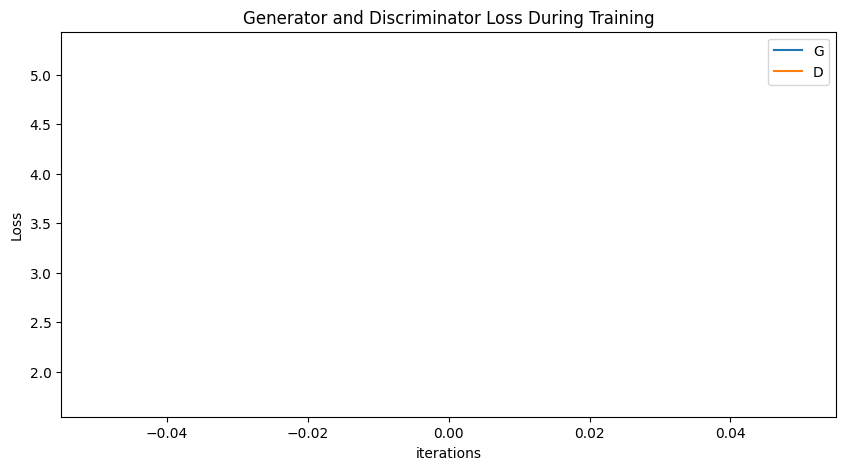

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Accuracy During Training**

The discriminator's accuracy is a measurement of how well it predicts if an image belongs to the
real dataset or is one of the generator's fake images. Here we plot the accuracy over time for
both the real and fake datasets. The generator's accuracy is the compliment of the discriminator's
accuracy for the fake dataset.


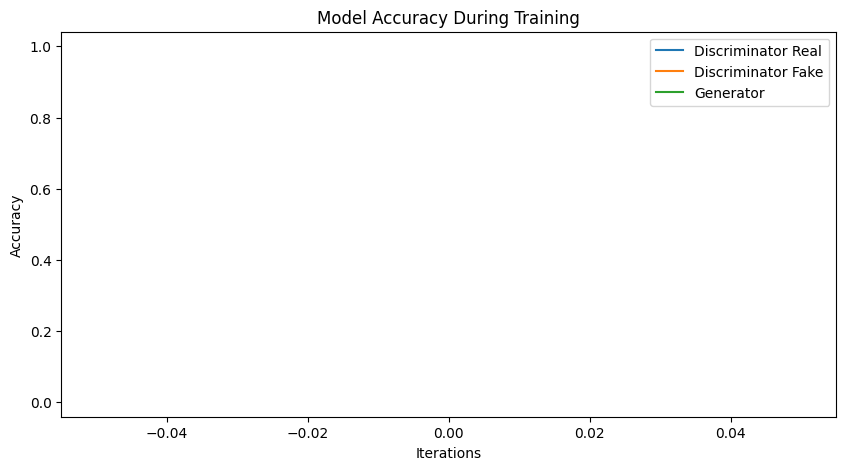

In [15]:
# Plot discriminator accuracy over time
plt.figure(figsize=(10,5))
plt.title("Model Accuracy During Training")
plt.plot(d_real_acc, label="Discriminator Real")
plt.plot(d_fake_acc, label="Discriminator Fake")
plt.plot(g_acc, label="Generator")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Visualization of Generator’s progression**

Here we can visualize the improvements of the DCGAN network output over time. As the generator
continues to learn how to trick the discriminator every iteration, the look of the images will
improve as they become harder and harder for the discriminator to distinguish from real images.
We have selected 1 image produced by the generator and are tracking it over time to see how it
improves.

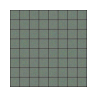

In [19]:
fig = plt.figure(figsize=(1,1))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=34, repeat_delay=1000, repeat=True, blit=True)
HTML(ani.to_jshtml())

**Final Comparison of Real and Fake Images**

Finally, a comparison of our finalized output images to the real images we provided to the model
as training data.

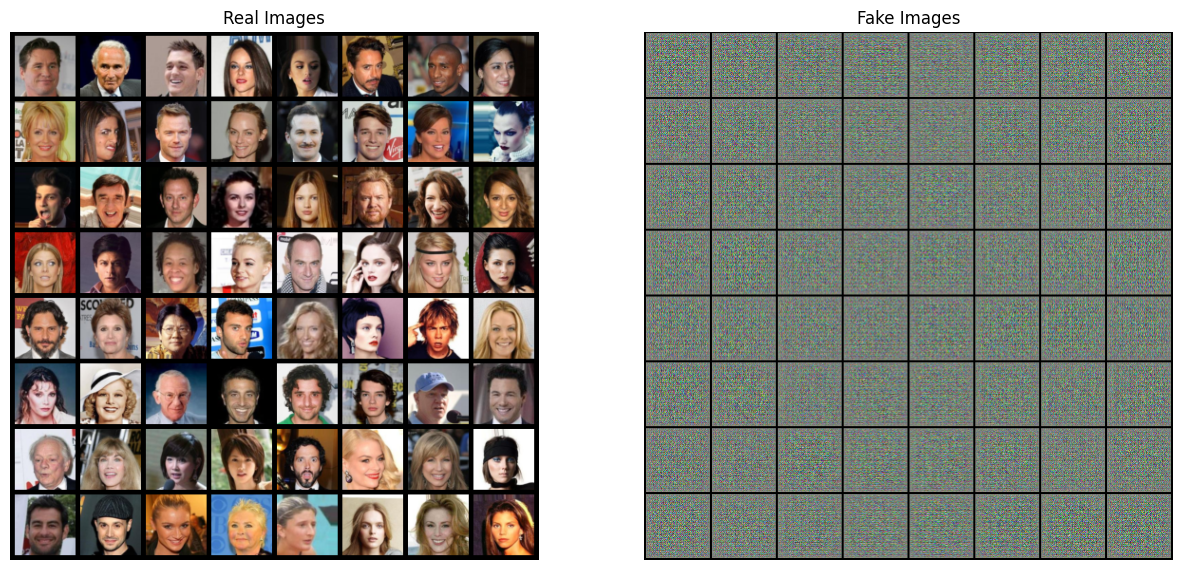

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1, 2, 0)))

# Plot fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

plt.show()